# Sparkify Project - Modeling and Evaluation

This is the last step of the project where the models are build, trained and evaluated. As in the feature engineering step, the features have to be created first and then the feature importance is loaded. Based on this importance, only the relevant features are kept and used for building the model. Finally, the scores of the models are caculated and visualized together with the different training times.

In [2]:
# import libraries
import datetime
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
sns.set(style="ticks")

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, OneHotEncoderEstimator, StringIndexer, VectorAssembler 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, udf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, StringType, TimestampType

# Load and Clean Dataset

Here the medium dataset file `medium-sparkify-event-data.json`is used. The loading part depends on whether you run this notebook locally or on a cluster from IBM Watson. Depending on this you need to comment or outcomment the following two cells as well as in later steps the loading of `feature_selection_df.csv`.

In [3]:
# loading when running on IBM cluster
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-809a258e-417e-4fa7-8cc0-a43a1f2c97b0',
    'iam_service_endpoint': 'https://iam.eu-de.bluemix.net/oidc/token',
    'api_key': 'izfH6CH03eyc2BUYHDOjmo9hUAQfaGy2HLRwdy1zfuEg'
}

configuration_name = 'os_6d7d9effed6f49088f222b405ed58a60_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

events = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-mukrompaxoq925'))

In [4]:
### uncomment this cell for local usage ###
# create a local Spark session if you want to run this notebook locally
#spark = SparkSession.builder \
#    .master("local") \
#    .appName("Sparkify") \
#    .getOrCreate()
# load the data from local source
#events = spark.read.json("data/mini_sparkify_event_data.json")

The userId contains values with an empty string. These entries need to be removed.

In [5]:
# events where a userId is an empty string are not valid, remove these
valid_events = events.where(col("userId") != "")
print("Number of total events: {}; number of valid events {}".format(events.count(), valid_events.count()))
print("Number of users: {}".format(valid_events.select("userId").distinct().count()))

Number of total events: 543705; number of valid events 528005
Number of users: 448


In [6]:
# registration and ts can both be converted to timestamps
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType()) # udf to convert to timestamp/date

In [7]:
valid_events = valid_events.withColumn("log_date", get_date(col("ts"))) # date when the log entry was done

In [8]:
# define a udf that checks for a churn action
find_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [9]:
# add a column "churn" to the dataframe indicating that a cancellation was confirmed
valid_events = valid_events.withColumn("churn", find_churn(col("page")))

In [10]:
# dataframe with the average length users listen to music
user_length = valid_events.groupBy("userId").agg({"length": "mean"}) \
    .withColumnRenamed("avg(length)", "avg_length")

In [11]:
# some values can be set into relation to a certain time period, e.g. the duration the user is active
# hence we need to create a df with all users and their active time period
# first find the first and last log entry for each user and how much log entries exist per user (all actions)
time_df = valid_events.groupBy(["userId"]) \
    .agg(F.sum("churn").alias("churned"), F.min("log_date").alias("first_log"),
         F.max("log_date").alias("last_log"), F.count("page").alias("log_counts"), F.max("ts").alias("last_ts"))

In [12]:
def get_time_difference(date_1, date_2):
    """Caculates the time difference between to dates in days.
    
    :param date_1: First date
    :type: datetime instance
    :param date_2: Second date
    :type: datetime instance
    :return: Difference between the two dates in days
    """
    # difference between the dates
    delta = date_2 - date_1
    
    # minimum difference is one 1
    if delta.days == 0:
        return 1
    else:
        return delta.days

# create a udf for this function
get_time_difference_udf = udf(get_time_difference, IntegerType())
# append duration and rename the churn column to label (helpful for model building later)
time_df = time_df.withColumn("duration", get_time_difference_udf(col("first_log"), col("last_log"))) \
            .drop("first_log", "last_log").withColumnRenamed("churned", "label")

In [13]:
# create a dummy dataframe where each action (About, Thumbs Up, ...) from page is a new column with the number
# how often this action appeared in the data for each user
dummy_df = valid_events.select("userId", "page").groupBy("userId").pivot("page") \
    .count().drop("Cancel", "Cancellation Confirmation")
# fill null values
dummy_df = dummy_df.na.fill(0)

In [14]:
# dataframe with the last level of each user
user_level = valid_events.orderBy("log_date", ascending=False).groupBy("userId").agg(F.first("level").alias('valid_level'))

In [15]:
# dataframe with the gender of each user
user_gender = valid_events.select(["userId", "gender"]).distinct()

In [16]:
# calculate the total amount of days the user listened to music
songs_per_date = valid_events.withColumn("date", F.to_date(col("log_date"))).where(col("page") == "NextSong") \
    .groupBy(["userId", "date"]).agg(F.lit(1).alias("played_music"))
songs_per_day = songs_per_date.groupBy("userId").agg(F.sum("played_music").alias("music_days"))

In [17]:
# join all previously created dataframes
df = time_df.join(dummy_df, on="userId").join(user_level, on="userId") \
    .join(user_gender, on="userId").join(user_length, on="userId").join(songs_per_day, on="userId")

In [18]:
# divide the actions by the amount of logs or the overall duration of their registration
def divide_columns_by(df, columns, value, appendix):
    """Generic function for dividing pyspark columns by a certain value.
    
    :param df: Dataframe containing the columns to divide
    :type: Pyspark Dataframe
    :param columns: Name of the columns to divide
    :type: list[str]
    :param value: Value the columns are divided with
    :type: int or float
    :appendix: String that is added to the new columns
    :type: str
    :return: Pyspark dataframe with new columns containing the division
    """
    for name in columns:
        new_name = name+"_"+appendix
        df = df.withColumn(new_name, col(name) / col(value))
    return df

In [19]:
# define which columns shall be divided by duration and log_counts
cols_to_divide = ['music_days', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home',
               'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
               'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']

In [20]:
# add columns for variables per duation
df_per = divide_columns_by(df, cols_to_divide, "duration", "per_day")
# add columns for variables per log_counts
df_model = divide_columns_by(df_per, cols_to_divide, "log_counts", "per_log")

In [ ]:
df_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- log_counts: long (nullable = false)
 |-- last_ts: long (nullable = true)
 |-- duration: integer (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- valid_level: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- music_days

In [ ]:
# numerical columns for the baseline model
numerical_baseline = ["About", "Add Friend", "Add to Playlist", "Downgrade", "Error",
                      "Help", "Home", "Logout", "NextSong", "Roll Advert", "Save Settings",
                      "Settings", "Submit Downgrade", "Submit Upgrade", "Thumbs Down",
                      "Thumbs Up", "Upgrade"]
# all columns for the baseline model
columns_baseline = ["label", "gender", "valid_level"] + numerical_baseline

# create dataframe for the baseline model
df_baseline = df_model.select(*columns_baseline)

## Selecting Numerical Features

In [ ]:
# load feature importance from csv when running notebook on IBM cluster
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6d7d9effed6f49088f222b405ed58a60 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='izfH6CH03eyc2BUYHDOjmo9hUAQfaGy2HLRwdy1zfuEg',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_6d7d9effed6f49088f222b405ed58a60.get_object(Bucket='sparkify-donotdelete-pr-mukrompaxoq925',Key='feature_selection_df.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

num_feature_df = pd.read_csv(body).drop("Unnamed: 0", axis=1)
num_feature_df.head()


,Feature,Pearson,RFE,Logistics,Random Forest,LightGBM,Total
0,last_ts,True,True,True,True,True,5
1,duration,True,True,True,True,True,5
2,music_days,True,True,True,False,True,4
3,Thumbs Down_per_log,True,True,True,True,False,4
4,Submit Upgrade_per_day,True,True,True,True,False,4


In [ ]:
### uncomment this cell when running locally ###
#num_feature_df = pd.read_csv("data/feature_selection_df.csv").drop("Unnamed: 0", axis=1)
#num_feature_df.head()

In [ ]:
# get all features which have at least a feature importance of 2
important_num_features = list(num_feature_df[num_feature_df["Total"] >= 2]["Feature"])
# creating a list of features which do not contain any duplicates e.g. not both Thumbs Down_per_log and Thumbs Down
unique_num_features = []
final_num_features = []
# iterate over all important features
for idx, f in enumerate(important_num_features):
    # strip the string if it contains per_day or _per_log
    if f.find("_per_day") > -1:
        f_stripped = f.replace("_per_day", "")
    elif f.find("_per_log") > -1:
        f_stripped = f.replace("_per_log", "")
    else:
        f_stripped = f
    # check if feature is already in or not
    if f_stripped not in unique_num_features:
        unique_num_features.append(f_stripped)
        final_num_features.append(f)
        
print("Final {} numerical features selected by feature importance: \n{}".format(len(final_num_features), final_num_features))

Final 22 numerical features selected by feature importance: 
['last_ts', 'duration', 'music_days', 'Thumbs Down_per_log', 'Submit Upgrade_per_day', 'NextSong_per_log', 'Add Friend_per_day', 'About', 'Submit Downgrade', 'Roll Advert', 'Home_per_day', 'Help_per_day', 'Downgrade', 'Add to Playlist', 'log_counts', 'avg_length', 'Upgrade_per_log', 'Thumbs Up_per_day', 'Settings_per_day', 'Save Settings_per_day', 'Logout_per_log', 'Error']


In [ ]:
# categorical variables which need to be encoded
categorical_columns = ["gender", "valid_level"]
# final columns/features used for the tuned models
columns_for_modeling = ["label"] +  categorical_columns + final_num_features
# select only final features
df_model = df_model.select(*columns_for_modeling)
df_model.printSchema()

root
 |-- label: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- valid_level: string (nullable = true)
 |-- last_ts: long (nullable = true)
 |-- duration: integer (nullable = true)
 |-- music_days: long (nullable = true)
 |-- Thumbs Down_per_log: double (nullable = true)
 |-- Submit Upgrade_per_day: double (nullable = true)
 |-- NextSong_per_log: double (nullable = true)
 |-- Add Friend_per_day: double (nullable = true)
 |-- About: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Home_per_day: double (nullable = true)
 |-- Help_per_day: double (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- log_counts: long (nullable = false)
 |-- avg_length: double (nullable = true)
 |-- Upgrade_per_log: double (nullable = true)
 |-- Thumbs Up_per_day: double (nullable = true)
 |-- Settings_per_day: double (nullable = true)
 |-- Save Settings_per_day: double (n

# Modeling

Now the machine learning pipelines with the different transformers and predictors are created.

In [43]:
# train and test data for the tuned models
# train = df_model.sampleBy("label", fractions={0: 0.8, 1: 0.5}, seed=42)
# test = df_model.subtract(train) # for balancing
train, test = df_model.randomSplit([0.8, 0.2], seed=42)

# train and test data for the baseline model
#train_baseline = df_baseline.sampleBy("label", fractions={0: 0.8, 1: 0.5}, seed=42)
#test_baseline = df_baseline.subtract(train_baseline)
train_baseline, test_baseline = df_baseline.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# handle categorical columns in pipeline
indexers = []
# add a stringindexer for each categorical column
for cat in categorical_columns:
    indexers.append(StringIndexer(inputCol = cat, outputCol = "{}_indexed".format(cat)))

# one encoder for all categorical columns
encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{}_encoded".format(indexer.getOutputCol()) for indexer in indexers])

In [ ]:
# one output vector for all numerical values
numeric_assembler = VectorAssembler(inputCols=final_num_features, outputCol="numeric_vectorized")
# scale the numerical variables
scaler = StandardScaler(inputCol = "numeric_vectorized", outputCol = "numeric_scaled", withStd = True, withMean = True)

#create final VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=["numeric_scaled"] + encoder.getOutputCols(), outputCol="features")

## Random Forest Model

In [ ]:
# random forest model and pipeline
model_rf = RandomForestClassifier(featuresCol="features", labelCol="label")
pipeline_rf = Pipeline(stages= indexers + [encoder, numeric_assembler, scaler, assembler, model_rf])

In [44]:
# param grid and crossvalidator for random forest with F1-score as evaluation metric
paramGrid_rf = ParamGridBuilder() \
        .addGrid(model_rf.numTrees, [25, 75]) \
        .addGrid(model_rf.maxDepth, [10, 30]) \
        .build() 
        # 10, 5
crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

## Logistic Regression

In [ ]:
# Initiate log regression model
model_lr = LogisticRegression()

# Make pipeline for lr
pipeline_lr = Pipeline(stages= indexers + [encoder, numeric_assembler, scaler, assembler, model_lr])

# param grid for logistic regression
paramGrid_lr = ParamGridBuilder() \
    .addGrid(model_lr.maxIter, [10, 20]) \
    .addGrid(model_lr.elasticNetParam, [0, 0.5]) \
    .addGrid(model_lr.regParam,[0.1, 1]) \
    .build()

# crossvalidator for logistic regression with same evaluation metric
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

## GBTC Classifier

In [ ]:
# Initiate log regression model
model_gbtc = GBTClassifier()

# Make pipeline for gbtc
pipeline_gbtc = Pipeline(stages= indexers + [encoder, numeric_assembler, scaler, assembler, model_gbtc])

# param grid for gbtc
paramGrid_gbtc = ParamGridBuilder() \
    .addGrid(model_gbtc.maxIter, [5, 10]) \
    .build()

# crossvalidator for gbtc with same evaluation metric
crossval_gbtc = CrossValidator(estimator=pipeline_gbtc,
                          estimatorParamMaps=paramGrid_gbtc,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

## Baseline

In [ ]:
# scale numeric variables from baseline data
numeric_assembler_baseline = VectorAssembler(inputCols=numerical_baseline, outputCol="numeric_vectorized")
scaler_baseline = StandardScaler(inputCol = "numeric_vectorized", outputCol = "numeric_scaled", withStd = True, withMean = True)


# final VectorAssembler to push data to ML models for the baseline
assembler = VectorAssembler(inputCols=["numeric_scaled"] + encoder.getOutputCols(), outputCol="features")
# choose random forest classifier as baseline
model_baseline = RandomForestClassifier(featuresCol="features", labelCol="label")
# add in pipeline for usage of the same functions later
pipeline_baseline = Pipeline(stages= indexers + [encoder, numeric_assembler_baseline, scaler_baseline, assembler, model_rf])

# add default parameters into the param grid
paramGrid_baseline = ParamGridBuilder() \
    .addGrid(model_rf.numTrees, [3]) \
    .addGrid(model_rf.maxDepth, [4]) \
    .build()

# crossvalidator for baseline with same evaluation metric
crossval_baseline = CrossValidator(estimator=pipeline_baseline,
                          estimatorParamMaps=paramGrid_baseline,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

# Fit Models and Evaluate

Finally, the models are fitted and evaluated on the test and training data.

In [ ]:
def fit_crossval(crossval, train):
    """Fits the model with the training data and measures training time.
    
    :param crossval: Crossvalidator containing the pipeline and param grid
    :param train: Pyspark dataframe with the training data as input for the model
    :return:
        cv_model: Fitted model
        train_time: Needed training time
    """
    start_time = time.time() # start
    cv_model = crossval.fit(train) # fit
    end_time = time.time() # end
    
    # training time
    train_time = round(end_time - start_time,2)
    
    print("Fitting the model took {} s.".format(train_time))
    return cv_model, train_time

In [ ]:
def evaluate_model(model, train, test, metric="f1"):
    """Calculate metric for the model on train and test data.
    
    :param model: Best model from a CrossValidator
    :param train: Pyspark dataframe containing the training data
    :param test: Pyspark dataframe containing the test data
    :param metric: Metric score which is calculate
    :return:
        score_train: Metric score on training data
        score_test: Metric score on test data
        feature_importance: Feature importance values as list
    """
    # init evaluator
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    
    # make predictions
    prediction_result_train = model.transform(train)
    prediction_result_test = model.transform(test)
    
    # calcualte the scores
    score_train = evaluator.evaluate(prediction_result_train)
    score_test = evaluator.evaluate(prediction_result_test)
    print("{} score on training data is {}".format(metric, score_train))
    print("{} score on test data is {}".format(metric, score_test))
    
    try:
        # works only when certain models are used
        feature_importance = model.stages[-1].featureImportances
    except:
        feature_importance = []
        
    return score_train, score_test, feature_importance

In [45]:
# init dict of which models to fit
crossval_dict = {}
crossval_dict["Baseline"] = crossval_baseline
crossval_dict["Random-Forest"] = crossval_rf
crossval_dict["Logistic Regression"] = crossval_lr
crossval_dict["GBTC"] = crossval_gbtc
# dict for results
result_dict = {}

# worth caching if more than one model is fitted, depending also on the dataset used
#if len(crossval_dict) > 1:
#    train.cache()
#    test.cache()

# train models and evaluate the results
for cv_key in crossval_dict:
    print("### Fitting {} model ###".format(cv_key))
    if cv_key == "Baseline":
        # fit model
        cv_model, train_time = fit_crossval(crossval_dict[cv_key], train_baseline)
        # evaluate model
        score_train, score_test, f_importance = evaluate_model(cv_model.bestModel, train_baseline, test_baseline)
    else:
        # fit model
        cv_model, train_time = fit_crossval(crossval_dict[cv_key], train)
        # evaluate it
        score_train, score_test, f_importance = evaluate_model(cv_model.bestModel, train, test)
        
    result_dict[cv_key] = [score_train, score_test, train_time, f_importance]

print("-------------Result Summary--------------")
print(result_dict)

### Fitting Baseline model ###
Fitting the model took 635.25 s.
f1 score on training data is 0.7477023407954568
f1 score on test data is 0.6435890581840863
### Fitting Random-Forest model ###
Fitting the model took 1700.99 s.
f1 score on training data is 1.0
f1 score on test data is 0.8902157971925413
### Fitting Logistic Regression model ###
Fitting the model took 1322.0 s.
f1 score on training data is 0.8363121797635641
f1 score on test data is 0.8227760264874404
### Fitting GBTC model ###
Fitting the model took 1376.17 s.
f1 score on training data is 0.9916532296850198
f1 score on test data is 0.8710213766437328
-------------Result Summary--------------
{'Baseline': [0.7477023407954568, 0.6435890581840863, 635.25, SparseVector(19, {2: 0.0284, 3: 0.0323, 4: 0.1033, 5: 0.0093, 6: 0.063, 8: 0.0186, 9: 0.1115, 11: 0.152, 13: 0.1444, 14: 0.0678, 15: 0.2631, 16: 0.0063})], 'Random-Forest': [1.0, 0.8902157971925413, 1700.99, SparseVector(24, {0: 0.2188, 1: 0.103, 2: 0.0401, 3: 0.0262, 4: 0

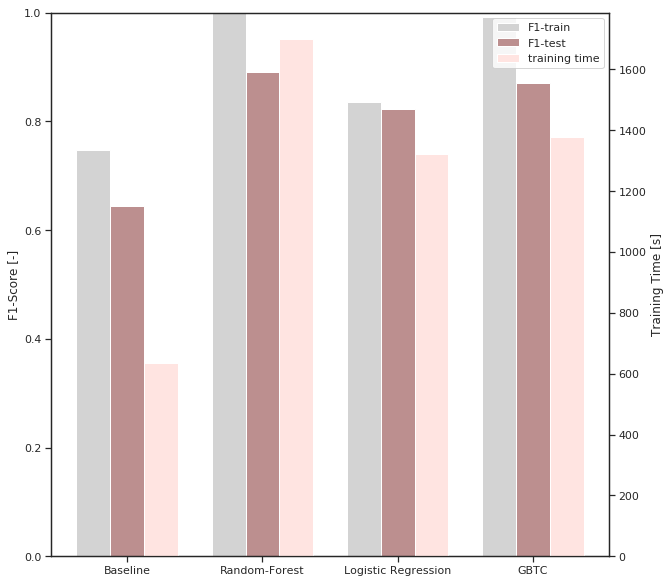

In [46]:
# create bar chart with scores and training times
fig, ax1 = plt.subplots(figsize=(10, 10)) 

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [r[0] for r in result_dict.values()]
bars2 = [r[1] for r in result_dict.values()]
bars3 = [r[2] for r in result_dict.values()]
 
# set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# make the plot for the scores
plot1 = ax1.bar(r1, bars1, color='lightgrey', width=barWidth, edgecolor='white', label='f1-train')
plot2 = ax1.bar(r2, bars2, color='rosybrown', width=barWidth, edgecolor='white', label='f1-test')
ax1.set_ylim(top=1) 
ax1.set_ylabel("F1-Score [-]")

# plot the runtime with same x-axis as scores
ax2 = ax1.twinx()
plot3 = ax2.bar(r3, bars3, color='mistyrose', width=barWidth, edgecolor='white', label='time')
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Training Time [s]")

# add legend for the two line plots in different axis
plt.legend([plot1, plot2, plot3], ["F1-train", "F1-test", "training time"])

# x-values
plt.xticks([r + barWidth for r in range(len(bars1))], result_dict.keys())

plt.show()

In [47]:
# feature importance of random forest
f_importance = result_dict["Random-Forest"][3]
f_names = final_num_features + categorical_columns
data = {"feature_names":  f_names,
        "feature_importance": f_importance,
        }

features_rf = pd.DataFrame (data, columns = ["feature_names", "feature_importance"])
features_rf.sort_values(["feature_importance"], ascending=False)

,feature_names,feature_importance
0,last_ts,0.218778
1,duration,0.103037
4,Submit Upgrade_per_day,0.064544
9,Roll Advert,0.063838
6,Add Friend_per_day,0.055125
17,Thumbs Up_per_day,0.047278
18,Settings_per_day,0.041991
2,music_days,0.040093
10,Home_per_day,0.036558
13,Add to Playlist,0.036218
